### Diversity in the Workplace
## Goal

Diversity, unconscious bias in the workplace and, in general, the way companies treat their
employees are a very important topic. Data science can help discover potential discriminations
by looking at the data and see if there are segments of employees that are treated worse.
Challenge Description
There has been lots of talking about diversity in the workplace, especially in technology. The
Head of HR at your company is very concerned about that and has asked you to analyze
internal data about employees and see whether results suggest that the company is treating its
employees fairly.
Specifically, she gave you the following tasks:
In the company there are 6 levels (described below). Identify, for each employee, her
corresponding level.
Individual Contributors (IC) - they don't manage anyone
Middle Managers (MM) - they are the direct bosses of IC
Directors (D) - they are the direct bosses of MM
VP - D direct bosses
Executives (E) - VP direct bosses
CEO - The direct boss of E.
How many people each employee manages? You should have a table with employee ids
and the number of people managed. Consider that if John directly manages 2 people and
these two people manage 5 people each, then we conclude that John manages 12
people.
### Build a model to predict the salary of each employee.
### Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
company = pd.read_csv('company_hierarchy.csv')
employee = pd.read_csv('employee.csv')

In [3]:
df = pd.merge(left=employee, right=company, on='employee_id')

In [4]:
df.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
 6   boss_id         9999 non-null   float64
 7   dept            10000 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 625.1+ KB


In [6]:
df.describe()

,employee_id,signing_bonus,salary,yrs_experience,boss_id
count,10000.000000,10000.000000,10000.000000,10000.000000,9999.000000
mean,100001.855800,0.301400,189111.800000,3.875200,103299.980498
std,57500.488641,0.458889,88973.796898,3.107409,57508.798817
min,40.000000,0.000000,60000.000000,1.000000,79.000000
25%,50574.500000,0.000000,110000.000000,2.000000,55883.000000
50%,99244.500000,0.000000,182000.000000,3.000000,102712.000000
75%,149748.500000,1.000000,255000.000000,5.000000,152288.000000
max,199956.000000,1.000000,700000.000000,34.000000,199950.000000


In [13]:
for col in df.columns:
    print(df[col].value_counts())

employee_id
99363     1
166912    1
185824    1
186728    1
177978    1
         ..
118607    1
29039     1
114657    1
3192      1
138719    1
Name: count, Length: 10000, dtype: int64
signing_bonus
0    6986
1    3014
Name: count, dtype: int64
salary
62000.0     74
61000.0     71
63000.0     65
83000.0     65
67000.0     64
            ..
385000.0     4
550000.0     2
500000.0     1
650000.0     1
700000.0     1
Name: count, Length: 344, dtype: int64
degree_level
PhD            2822
Master         2786
Bachelor       2735
High_School    1657
Name: count, dtype: int64
sex
M    6439
F    3561
Name: count, dtype: int64
yrs_experience
1     1920
2     1890
3     1777
4     1369
5     1063
6      659
7      447
8      267
9      167
10      77
11      72
13      65
14      58
12      54
19      14
18      13
15      12
16      11
20      11
17      10
21       8
24       8
22       7
23       6
26       4
33       3
27       2
32       2
30       2
34       1
28       1
Name: count, dtype:

### Identify, for each employee, her corresponding level. Individual Contributors (IC) - they don't manage anyone Middle Managers (MM) - they are the direct bosses of IC Directors (D) - they are the direct bosses of MM VP - D direct bosses Executives (E) - VP direct bosses CEO - The direct boss of E. How many people each employee manages? You should have a table with employee ids and the number of people managed

In [14]:
managed_counts = df.groupby("boss_id")["employee_id"].count().reset_index()
managed_counts.columns = ["employee_id", "num_managed"]

In [25]:
print(managed_counts)

     employee_id  num_managed
0           79.0            9
1           90.0            8
2          252.0           10
3          742.0           17
4          754.0           16
..           ...          ...
994     198879.0           13
995     198893.0            2
996     199184.0           15
997     199282.0           12
998     199950.0            9

[999 rows x 2 columns]


In [16]:
df = df.merge(managed_counts, on="employee_id", how="left")
df["num_managed"] = df["num_managed"].fillna(0).astype(int)

In [17]:
boss_map = dict(zip(df["employee_id"], df["boss_id"]))

In [18]:
def find_level(emp):
    level = 0
    while not pd.isna(boss_map.get(emp)):
        emp = boss_map[emp]
        level += 1
    return level
df["level_num"] = df["employee_id"].apply(find_level)

In [19]:
level_names = {0: "CEO", 1: "E", 2: "VP", 3: "D", 4: "MM", 5: "IC"}
df["level"] = df["level_num"].map(level_names)

In [20]:
df.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,num_managed,level_num,level
0,138719,0,273000.0,Master,M,2,43602.0,engineering,0,5,IC
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,0,5,IC
2,114657,0,261000.0,Master,F,2,180854.0,sales,0,5,IC
3,29039,0,86000.0,High_School,F,4,88370.0,HR,0,5,IC
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,0,5,IC


### How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [27]:
df["counts"] = 0
for level in ["IC", "MM", "D", "VP", "E"]:
    for _, row in df[df["level"] == level].iterrows():
        boss_id = row["boss_id"]
        if pd.notna(boss_id):
            employee_count = 1 + df.loc[df["employee_id"] == row["employee_id"], "counts"].values[0]
            df.loc[df["employee_id"] == boss_id, "counts"] += employee_count

In [28]:
df[['employee_id', 'level', 'counts']].sample(5)

,employee_id,level,counts
6261,148380,IC,0
4322,192414,MM,9
462,114505,IC,0
5038,183175,D,67
1782,15405,IC,0


# visualize data

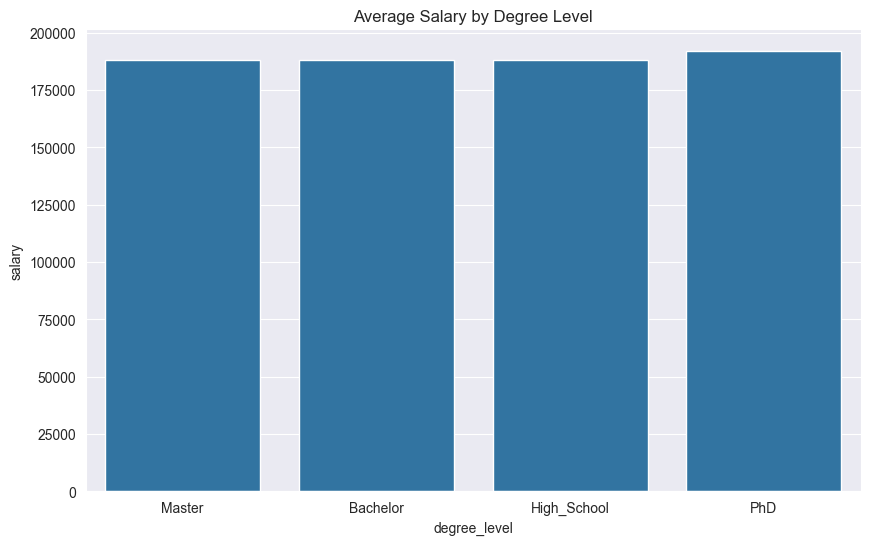

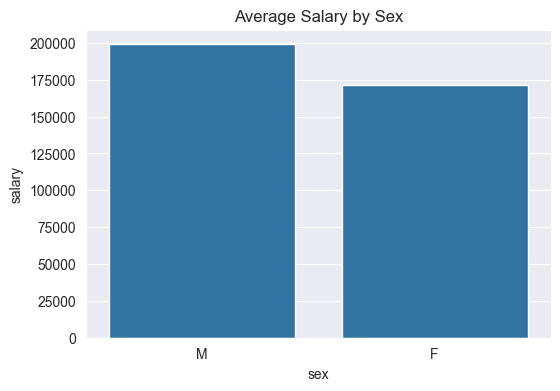

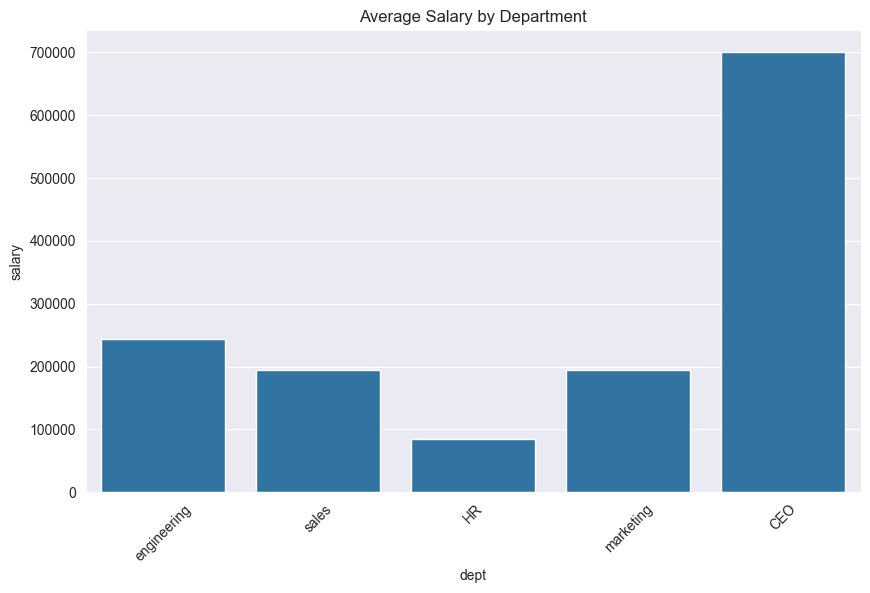

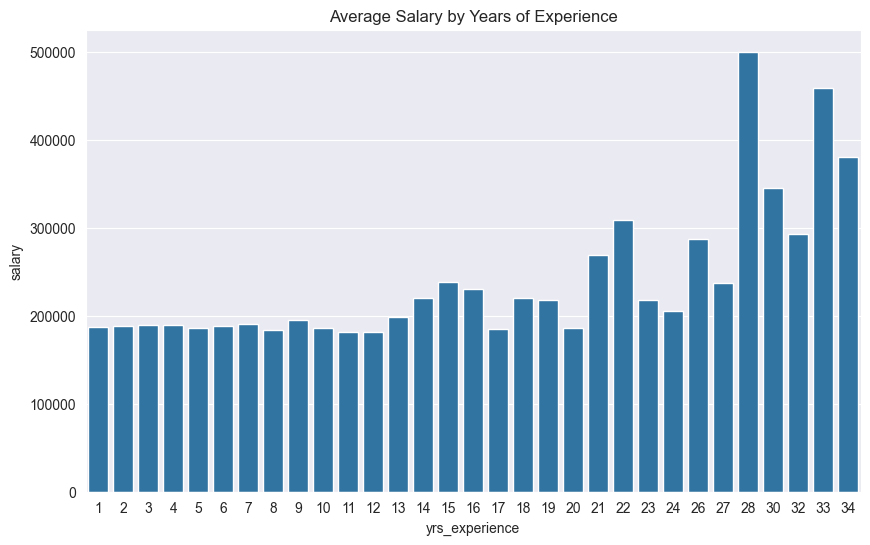

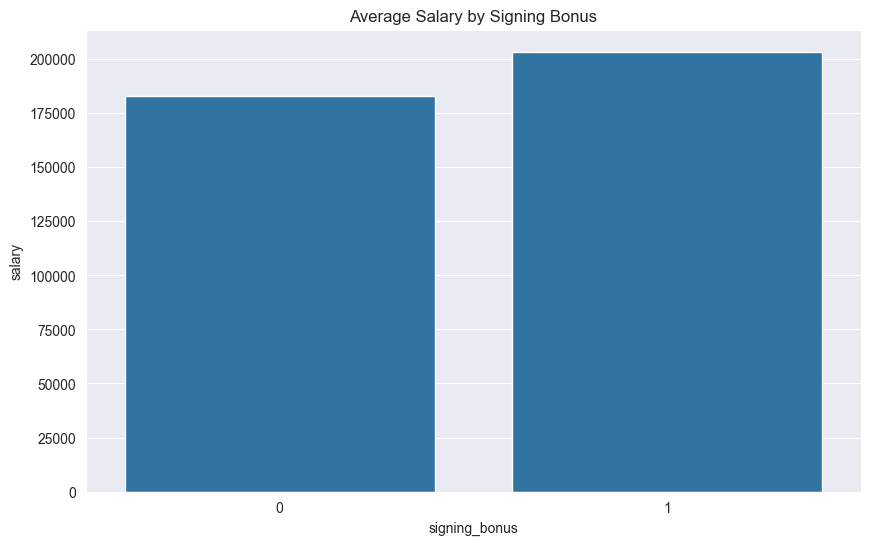

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='degree_level', y='salary', data=df, errorbar=None)
plt.title('Average Salary by Degree Level')
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x='sex', y='salary', data=df, errorbar=None)
plt.title('Average Salary by Sex')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='dept', y='salary', data=df, errorbar=None)
plt.title('Average Salary by Department')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='yrs_experience', y='salary', data=df, errorbar=None)
plt.title('Average Salary by Years of Experience')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='signing_bonus', y='salary', data=df,errorbar=None)
plt.title('Average Salary by Signing Bonus')
plt.show()

### Build the model

In [39]:
X = df.drop(columns=["salary"])
y = df["salary"]

In [40]:
cat_cols = ["degree_level", "sex", "dept" , "level"]
num_cols = ["signing_bonus", "yrs_experience"]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

In [41]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42, n_estimators=100))
])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
model.fit(X_train, y_train)

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['degree_level', 'sex',
                                                   'dept', 'level'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [44]:
y_pred = model.predict(X_test)

In [45]:
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

MAE: 57479.60
MSE: 5476045767.75
RMSE: 74000.31
R2 Score: 0.29


### Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?


--- Feature Importance ---
                     feature  importance
7                    dept_HR    0.280928
17               employee_id    0.239621
20                   boss_id    0.197882
19            yrs_experience    0.073872
8           dept_engineering    0.055236
18             signing_bonus    0.020304
23                    counts    0.017624
0      degree_level_Bachelor    0.016162
2        degree_level_Master    0.015885
3           degree_level_PhD    0.015661
1   degree_level_High_School    0.013450
5                      sex_M    0.010961
4                      sex_F    0.010837
21               num_managed    0.009045
10                dept_sales    0.006884
9             dept_marketing    0.006676
22                 level_num    0.004560
15                  level_MM    0.001517
14                  level_IC    0.001292
6                   dept_CEO    0.000485
12                   level_D    0.000351
16                  level_VP    0.000335
11                 level_CEO 

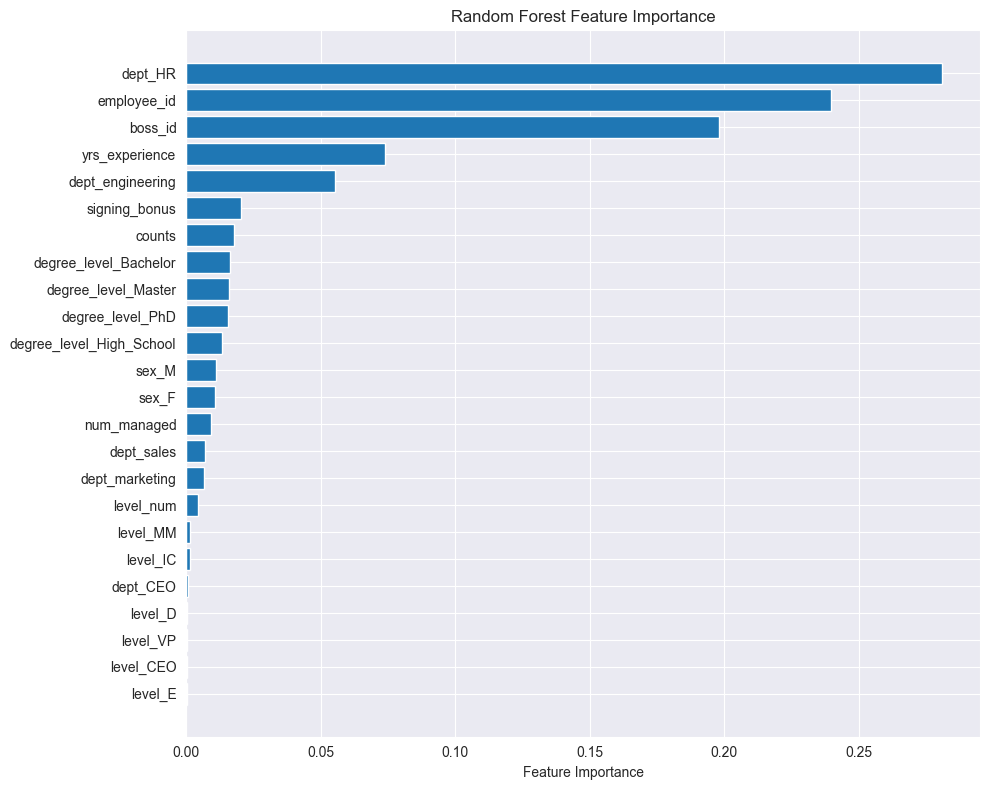

In [56]:
feature_names = (
    model.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols).tolist() +
    [col for col in X.columns if col not in cat_cols]
)
importances = model.named_steps["regressor"].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
print("\n--- Feature Importance ---")
print(feature_importance_df)
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The chart shows what affects how much employees get paid. The most important thing is which department they work in, especially HR. Next are employee ID and boss ID, then years of experience and engineering. It’s not good that pay depends on employee or boss ID because these are just numbers or people and should not decide salary. This means pay might be unfair. It’s okay that experience matters because that is fair. But the big difference between departments means some groups get paid more unfairly. Degree and gender don’t affect pay much, so the company seems fair in those areas. I think HR should check if everyone is paid fairly. They should make clear rules so pay depends on experience and work, not department or boss. They should make pay rules easy to understand and make sure people with the same jobs get paid the same, no matter their department. They also need to fix why HR has so much power over pay and stop bosses from deciding pay unfairly.